## Further methylation preprocessing steps

The steps in `1B_preprocess_27K_methylation_data.ipynb` and `1C_preprocess_450K_methylation_data.ipynb` are very basic, so we want to try a few other things that people commonly do before methylation analyses, to make sure that our results aren't dependent on our preprocessing steps (or lack thereof).

To start with, we'll try these things on the 27K data, and we'll extend them to the 450K data later if they seem to have some effect on our results.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from venn import venn

import mpmp.config as cfg
import mpmp.utilities.tcga_utilities as tu

In [2]:
# if SAVE_RESULTS = True, overwrite existing data files generated by this script
# this can be slow, so for debugging/visualization it may make sense to set to False
SAVE_RESULTS = False

### Load data

Load methylation data (just 27K for now) and Illumina manifest data.

The Illumina manifest maps probes to their probe type (type I or II), their chromosome/nearest gene, their functional classification (e.g. TSS, gene body, UTR, etc), and lots of other information about each probe.

In [3]:
tcga_methylation_df = (
    pd.read_csv(cfg.methylation_27k_data, index_col=0, sep='\t')
      .transpose()
)

print(tcga_methylation_df.shape)
tcga_methylation_df.iloc[:5, :5]

(20040, 11975)


,TCGA-02-0001-01,TCGA-02-0003-01,TCGA-02-0006-01,TCGA-02-0007-01,TCGA-02-0009-01
cg00000292,0.8460,0.732,0.6790,0.8470,0.8550
cg00003994,0.0664,0.131,0.0897,0.0409,0.0661
cg00005847,0.3310,0.839,0.4690,0.3550,0.6050
cg00008493,0.9260,0.934,0.9250,0.9300,0.9270
cg00008713,0.0606,0.165,0.0616,0.0605,0.0614


In [3]:
if os.path.isfile(cfg.methylation_manifest):
    manifest_df = pd.read_csv(
        cfg.methylation_manifest,
        index_col=0
    )
else:
    # if manifest file hasn't already been downloaded, get it from Illumina website
    print('loading manifest from URL')
    manifest_df = pd.read_csv(
        cfg.manifest_url,
        header=7, # skip first 6 lines
        index_col=0
    )
    manifest_df.to_csv(cfg.methylation_manifest)
    
manifest_df.iloc[:5, :5]

/home/jake/anaconda3/envs/mpmp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (2,4,11,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Name,AddressA_ID,AlleleA_ProbeSeq,AddressB_ID,AlleleB_ProbeSeq
IlmnID,,,,,
cg00035864,cg00035864,31729416,AAAACACTAACAATCTTATCCACATAAACCCTTAAATTTATCTCAA...,NaN,NaN
cg00050873,cg00050873,32735311,ACAAAAAAACAACACACAACTATAATAATTTTTAAAATAAATAAAC...,3.17174e+07,ACGAAAAAACAACGCACAACTATAATAATTTTTAAAATAAATAAAC...
cg00061679,cg00061679,28780415,AAAACATTAAAAAACTAATTCACTACTATTTAATTACTTTATTTTC...,NaN,NaN
cg00063477,cg00063477,16712347,TATTCTTCCACACAAAATACTAAACRTATATTTACAAAAATACTTC...,NaN,NaN
cg00121626,cg00121626,19779393,AAAACTAATAAAAATAACTTACAAACCAAATACTATACCCTACAAC...,NaN,NaN


Text(0.5, 1.0, 'Probe overlap between Illumina manifest and TCGA dataset')

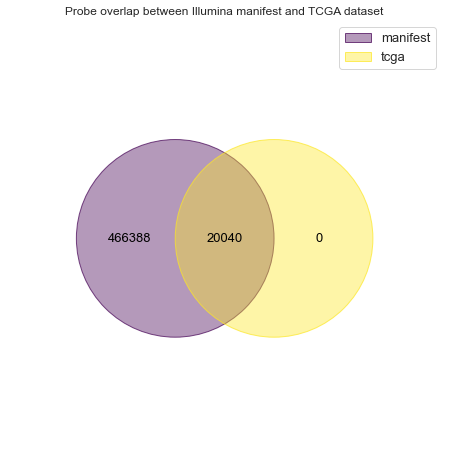

In [5]:
# look at overlap of probes in manifest and probes in TCGA dataset
# all probes in TCGA should be in manifest, but good to make sure
manifest_probes = manifest_df.index
tcga_probes = tcga_methylation_df.index

sns.set_style('white')
venn({'manifest': set(manifest_probes),
      'tcga': set(tcga_probes)})
plt.title('Probe overlap between Illumina manifest and TCGA dataset')

In [6]:
# get probe type (type I or type II) for TCGA probes from manifest
tcga_methylation_df = (tcga_methylation_df
    .merge(manifest_df[['Infinium_Design_Type', 'CHR']],
           left_index=True, right_index=True)
    .astype({'CHR': 'str'})
    .rename(columns={'Infinium_Design_Type': 'probe_type',
                     'CHR': 'chromosome'})
)
# check for NA rows, shouldn't be any
print('NA rows: {}'.format(
    tcga_methylation_df.shape[0] - tcga_methylation_df.dropna().shape[0]))
tcga_methylation_df.iloc[:5, -5:]

NA rows: 0


,TCGA-X7-A8D7-11,TCGA-YB-A89D-11,TCGA-ZU-A8S4-11,probe_type,chromosome
cg00000292,0.8800,0.6760,0.7140,II,16
cg00003994,0.0398,0.0536,0.0633,II,7
cg00005847,0.1550,0.3210,0.1530,II,2
cg00008493,0.9420,0.9300,0.9100,II,14
cg00008713,0.0612,0.0695,0.0658,II,18


### Probe filtering

We want to try removing certain classes of methylation probes:

* Probes on sex chromosomes (X or Y chromosome)
* Cross-reactive probes (these were identified in [Chen et al. 2013](https://doi.org/10.4161/epi.23470), we downloaded them using the [maxprobes R package](https://github.com/markgene/maxprobes))

Both of these probe classes could provide spurious signal for classification/regression modeling.

In [7]:
cross_reactive_probes = pd.read_csv(cfg.cross_reactive_probe_list, 
                                    header=None,
                                    index_col=0,
                                    squeeze=True)
cross_reactive_probes.head()

""
0
cg00001510
cg00003969
cg00004121
cg00004192
cg00004209


Text(0.5, 1.0, 'Probe overlap between cross-reactive probe list and TCGA dataset')

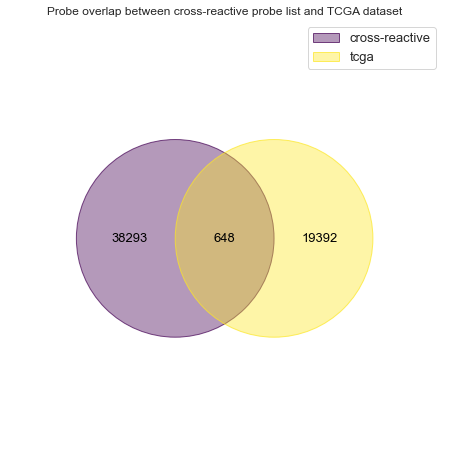

In [8]:
# look at overlap of cross-reactive probes and probes in TCGA dataset
sns.set_style('white')
venn({'cross-reactive': set(cross_reactive_probes.index),
      'tcga': set(tcga_probes)})
plt.title('Probe overlap between cross-reactive probe list and TCGA dataset')

In [9]:
print(tcga_methylation_df.shape)
tcga_methylation_df = (
    tcga_methylation_df[(~tcga_methylation_df.chromosome.isin(['X', 'Y'])) &
                        (~tcga_methylation_df.index.isin(cross_reactive_probes.index))]
)
print(tcga_methylation_df.shape)

(20040, 11977)
(18698, 11977)


In [10]:
if SAVE_RESULTS:
    
    # save probe types
    # BMIQ expects these to be labeled as 1/2 rather than I/II, so change them here
    tcga_methylation_df.loc[tcga_methylation_df.probe_type == 'I', 'probe_type'] = 1
    tcga_methylation_df.loc[tcga_methylation_df.probe_type == 'II', 'probe_type'] = 2
    tcga_methylation_df['probe_type'].to_csv(
        os.path.join(cfg.data_dir, 'methylation_27k_filtered_probe_types.txt')
    )

    # save methylation data without probe metadata
    (tcga_methylation_df
        .drop(columns=['chromosome', 'probe_type'])
        .transpose()
        .to_csv(os.path.join(cfg.data_dir, 'methylation_27k_filtered_probes.tsv'),
                sep='\t')
    )

### Normalize type I vs. type II beta values

This happens on the sample level.

TODO call R script to do this if necessary, probs using `subprocess`

In [11]:
tcga_norm_df = (
    pd.read_csv(os.path.join(cfg.data_dir, 'methylation_27k_bmiq_normalized_t.tsv'),
                sep='\t', index_col=0)
      .merge(manifest_df[['Infinium_Design_Type', 'CHR']],
             left_index=True, right_index=True)
      .astype({'CHR': 'str'})
      .rename(columns={'Infinium_Design_Type': 'probe_type',
                       'CHR': 'chromosome'})
      #.transpose()
)
# R replaces hyphens in columns with dots, so we need to switch them back
tcga_norm_df.columns = tcga_norm_df.columns.str.replace('.', '-')
print(tcga_norm_df.shape)
tcga_norm_df.iloc[:5, -5:]

(18698, 11977)


,TCGA-X7-A8D7-11,TCGA-YB-A89D-11,TCGA-ZU-A8S4-11,probe_type,chromosome
cg00000292,0.962568,0.731270,0.766099,II,16
cg00003994,0.019032,0.023878,0.026287,II,7
cg00005847,0.118961,0.314197,0.107466,II,2
cg00008493,0.990638,0.979882,0.974218,II,14
cg00008713,0.029334,0.033075,0.027330,II,18


In [12]:
print(np.count_nonzero(tcga_norm_df.isna().sum(axis=0)))

106


In [13]:
tcga_norm_df.dropna(axis='columns', inplace=True)
print(tcga_norm_df.shape)

if SAVE_RESULTS:
    (tcga_norm_df
      .drop(columns=['probe_type', 'chromosome'])
      .transpose()
      .to_csv(os.path.join(cfg.data_dir, 'methylation_27k_bmiq_normalized_nona.tsv'),
              sep='\t'))

In [17]:
from sklearn.decomposition import PCA

pca_dir = os.path.join(cfg.data_dir, 'me_compressed')
os.makedirs(pca_dir, exist_ok=True)

# tcga_norm_df = (tcga_norm_df
#   .drop(columns=['probe_type', 'chromosome'])
#   .transpose()
# )

n_pcs_list = [100, 1000, 5000]
var_exp_list = []
for n_pcs in n_pcs_list:
    pca = PCA(n_components=n_pcs, random_state=cfg.default_seed)
    me_pca = pca.fit_transform(tcga_norm_df)
    print(me_pca.shape)
    var_exp_list.append(pca.explained_variance_ratio_)
    me_pca = pd.DataFrame(me_pca, index=tcga_norm_df.index)
    me_pca.to_csv(os.path.join(pca_dir,
                               'me_27k_bmiq_pc{}.tsv.gz'.format(n_pcs)),
                  sep='\t',
                  float_format='%.3g')

(11869, 100)
(11869, 1000)
(11869, 5000)


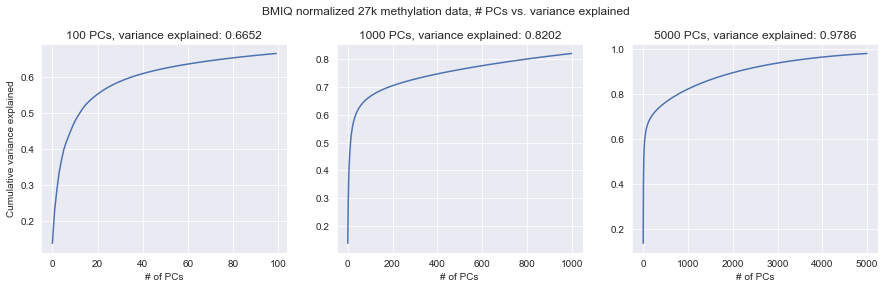

In [18]:
# plot PCA variance explained
sns.set({'figure.figsize': (15, 4)})
fig, axarr = plt.subplots(1, 3)

for ix, ve in enumerate(var_exp_list):
    sns.lineplot(x=range(len(ve)), y=np.cumsum(ve), ax=axarr[ix])
    axarr[ix].set_title('{} PCs, variance explained: {:.4f}'.format(
        n_pcs_list[ix], sum(ve, 0)))
    axarr[ix].set_xlabel('# of PCs')
    if ix == 0:
        axarr[ix].set_ylabel('Cumulative variance explained')
plt.suptitle('BMIQ normalized 27k methylation data, # PCs vs. variance explained')
plt.subplots_adjust(top=0.85)

In [ ]:
# sample n_samples probes of each type
# using all the samples takes forever to run and produces a plot that's hard to read
n_samples = 100
tI_probes = (
    tcga_norm_df[tcga_norm_df.probe_type == 'I']
      .sample(n=n_samples, random_state=cfg.default_seed)
)
tII_probes = (
    tcga_norm_df[tcga_norm_df.probe_type == 'II']
      .sample(n=n_samples, random_state=cfg.default_seed)
)

sns.set_style('whitegrid')
sns.set({'figure.figsize': (8, 6)})
 
for ix, (probe, row) in enumerate(tI_probes.iterrows()):
    betas = row.values[:-2].astype('float')
    if ix == 0:
        sns.kdeplot(x=betas, color='red', label='type I')
    else:
        sns.kdeplot(x=betas, color='red')
    
for ix, (probe, row) in enumerate(tII_probes.iterrows()):
    betas = row.values[:-2].astype('float')
    if ix == 0:
        sns.kdeplot(x=betas, color='green', label='type II')
    else:
        sns.kdeplot(x=betas, color='green')
    
plt.title(r'Distribution of $\beta$ values for {} samples'.format(n_samples))
plt.xlabel(r'$\beta$')
plt.legend()

In [ ]:
# single distribution from all probes of each type
n_samples = 100000
all_tI_probes = np.random.choice(
    tcga_norm_df[tcga_norm_df.probe_type == 'I']
      .drop(columns=['probe_type', 'chromosome'])
      .values.astype('float').flatten()
, size=n_samples)
all_tII_probes = np.random.choice(
    tcga_norm_df[tcga_norm_df.probe_type == 'II']
      .drop(columns=['probe_type', 'chromosome'])
      .values.astype('float').flatten()
, size=n_samples)

sns.set_style('whitegrid')
sns.set({'figure.figsize': (8, 6)})
 
sns.kdeplot(x=all_tI_probes, color='red', label='type I')
sns.kdeplot(x=all_tII_probes, color='green', label='type II')
    
plt.title(r'Distribution of $\beta$ values, all probes combined, {} samples'.format(n_samples))
plt.xlabel(r'$\beta$')
plt.legend()